#  Masking Pipeline

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)


In [ ]:
#!env

In [ ]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *

In [ ]:
%matplotlib inline

In [ ]:
#%matplotlib notebook

In [5]:
from pyCHX.chx_generic_functions import RemoveHot,create_multi_rotated_rectangle_mask

# Path for Saving Results

In [18]:
CYCLE= '2019_3'  #change clycle here

In [19]:
path = '/XF11ID/analysis/%s/masks/'%CYCLE
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2019_3/masks/


### Get the image series and metadata from the uid

In [73]:
uid = '09c84e03' #(scan num: 23307) (Measurement: single image 4M )
uid = 'ff77f1fb' #(scan num: 24345) (Measurement: 4M single image )
uid = '13618743' #(scan num: 24403) (Measurement: Single image - offset detector TM_gel #2 )
#Maria 4 Nov 2019
uid = 'b3260e2c' #(scan num: 25143) (Measurement: image: for mask 4M )
uid = '7d93c742' #(scan num: 25142) (Measurement: images: for mask 500k )

In [74]:
#get_last_uids( -2 )
#path

In [75]:
md = get_meta_data( uid )
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])

print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

filepath : /nsls2/xf11id1/data/2019/11/03/995c2a31-eca3-49a5-af54
got images_per_file
Detector is:  eiger500K_single_image
scan_id, full-uid, data path are:  25142--7d93c742-0cca-4fe4-8209-957c0260d4a2--/nsls2/xf11id1/data/2019/11/03/995c2a31-eca3-49a5-af54_69_master.h5


In [76]:
#print(md['beam_center_y'], md['beam_center_x'])

In [77]:
imgs = load_data( uid, detector, reverse= False  )
#imgs = load_data( uid, detector, reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

The data are: (EigerImages,) processed through proc_func. Original repr:
    <Frames>
    Length: 50 frames
    Frame Shape: 514 x 1030
    Pixel Datatype: uint16


In [78]:
pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [79]:
img_choice_N = 1  #can change this number to select more frames for average
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgs, img_samp_index, plot_ = False, uid = uid)

## show image and the pixel mask

* show image

In [80]:
#%matplotlib notebook

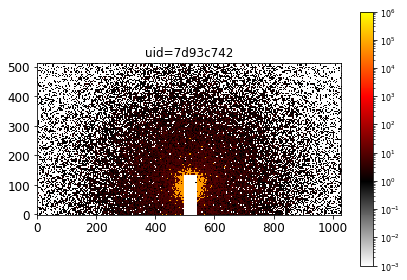

In [81]:
show_img(  avg_img*pixel_mask , vmin=.001, vmax=1e6, logs=True, 
         image_name ='uid=%s'%uid, aspect=1, cmap= cmap_albula  )


* pixel mask

### Update Pixel Mask due to bad pixel of Eiger Detector

In [82]:
pixel_mask = mask_badpixels( pixel_mask, md['detector'])

In [83]:
#%run /nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/chx_generic_functions.py
#mask_badpixels??

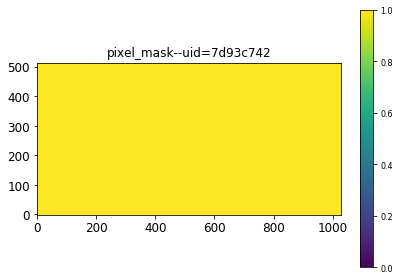

In [87]:
show_img( pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid ,aspect=1 )

## Remove hotspots in the image

In [88]:
#pixel_mask[750:788,1137]
#avg_img =  get_avg_img( imgs, sampling = 10, plot_ = False, uid =uid)

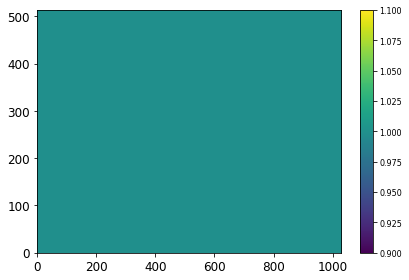

In [89]:
mask_rh  = RemoveHot( avg_img, 2**22-1, plot_=True)

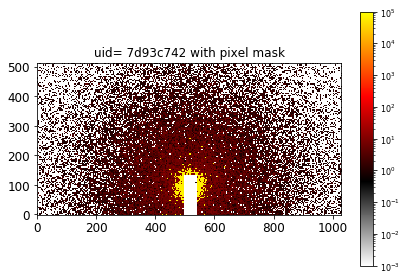

In [90]:
show_img(avg_img*pixel_mask,vmin=0.1e-2,vmax=1e5, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula  )

# Create a polygon mask

* check beam center

In [91]:
md['beam_center_x'], md['beam_center_y']

(515.0, 96.0)

In [92]:
#md['beam_center_x'] - 960, md['beam_center_y']-2167,  md['beam_center_y'] - 1400

In [93]:
imgs[0].shape

(514, 1030)

## Create a rotated region

In [94]:
rmask = create_multi_rotated_rectangle_mask( imgs[0], 
                                center= [ md['beam_center_x'], md['beam_center_y']   ], length=0, width=0, angles=[0] )

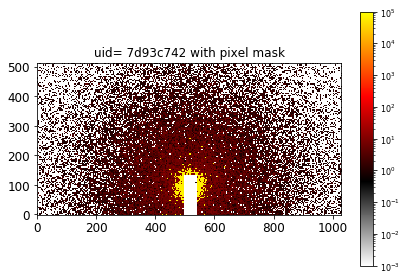

In [95]:
show_img(avg_img*pixel_mask*rmask,vmin=0.1e-2,vmax=1e5, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula  )

### To create multi-rectangle masks, for each sub-mask



In [96]:
#creat the right part mask

if '4m' in md['detector']:
    partial_mask = create_cross_mask(  avg_img, center=[md['beam_center_x']- 60, md['beam_center_y']  ], #center=[509,185],
                            wy_left= 0, wy_right= 40, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )
    ##for GiSAXS
    #partial_mask = create_cross_mask(  avg_img, center=[md['beam_center_x']- 200, 
    #                                                    md['beam_center_y']  ], #center=[509,185],
    #                        wy_left= 0, wy_right= 79, 
    #                          wx_up= 0, wx_down= 0,center_radius= 0 )    
    
elif '500K' in md['detector']:
    partial_mask = create_cross_mask(  avg_img, center=[md['beam_center_x'] , md['beam_center_y']+45  ], #center=[509,185],
                               wy_left= 0, wy_right= 0, 
                               wx_up= 0, wx_down= 25,center_radius= 0 )
else:
    print('Please check the detectors.')



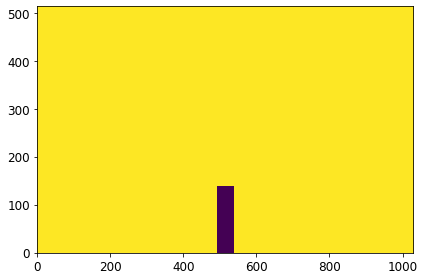

In [97]:
show_img(  partial_mask, show_colorbar=False   )

In [98]:
#np.save( '/XF11ID/analysis/2017_1/masks/Ver_Beamstop', partial_mask )
#Ver_Beamstop = np.load( '/XF11ID/analysis/2017_1/masks/Ver_Beamstop.npy' )
#Ver_Beamstop = move_beamstop( Vertical_Beamstop, xshift=0, yshift=0 )

In [99]:
#parasitic scattering from slits
partial_mask *= create_cross_mask(  avg_img,center= [ md['beam_center_x'], md['beam_center_y']   ],
                            wy_left= 8, wy_right= 8, 
                            wx_up= 8, wx_down= 8,center_radius= 0 )
#parasitic scattering from slits
#partial_mask *= create_cross_mask(  avg_img,center=[946,1700],
#                            wy_left= 0, wy_right= 0, 
#                            wx_up= 0, wx_down= 0,center_radius= 0 )
#parasitic scattering from slits
#partial_mask *= create_cross_mask(  avg_img,center=[ 946,2167-60],
#                            wy_left= 0, wy_right= 0, 
#                            wx_up= 0, wx_down= 0,center_radius= 0 )


In [100]:
#Some bad lines between chips - should be masked elswhere
#partial_mask[1909:1910,:] = False
#partial_mask[257:259,:] = False

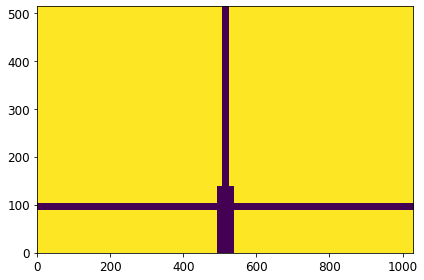

In [101]:
show_img(  partial_mask, show_colorbar=False   )

In [102]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ md['beam_center_x'], md['beam_center_y'] ],
                            wy_left= 10, wy_right= 10, 
                              wx_up= 10, wx_down=10,center_radius=0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [103]:
#creat the left/right/up/down part mask
#partial_mask *=  create_cross_mask(  avg_img, center=[ 1600,1800+25 ],
#                            wy_left= 0, wy_right= 0, 
#                              wx_up= 0, wx_down=0,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [104]:
#from chxanalys.chx_generic_functions import create_multi_rotated_rectangle_mask

In [105]:
#np.save( '/XF11ID/analysis/2017_1/masks/Hor_Beamstop', partial_mask )
#Hor_Beamstop = np.load( '/XF11ID/analysis/2017_1/masks/Hor_Beamstop.npy' )
#Hor_Beamstop = move_beamstop( Hor_Beamstop, xshift=0, yshift=0 )

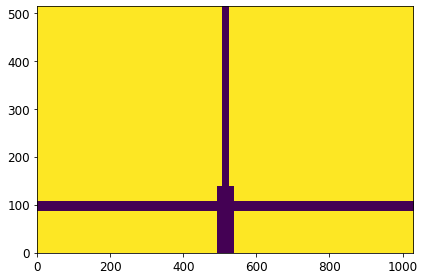

In [106]:
show_img(  partial_mask , show_colorbar=False   )

In [107]:
#creat the left/right/up/down part mask
#partial_mask *=  create_cross_mask(  avg_img, center=[ md['beam_center_x'], md['beam_center_y']-700],
#                            wy_left= 0, wy_right= 0, 
#                              wx_up= 40, wx_down= 0,center_radius= 0 )


In [108]:
#np.save( '/XF11ID/analysis/2017_1/masks/Bad_4M', partial_mask )
#Bad_4M = np.load( '/XF11ID/analysis/2017_1/masks/Bad_4M.npy' )
 

In [109]:
#create a circle mask for windows
if False: #make it True to make window mask
    window_shadow  = ~create_cross_mask(  avg_img, center=[ 911,997],
                           wy_left= 0, wy_right= 0, 
                             wx_up= 0, wx_down= 0,center_circle=True, center_radius= 680)
else:
    window_shadow = 1

In [110]:
full_mask = partial_mask *window_shadow
#full_mask = Ver_Beamstop * Hor_Beamstop *Bad_4M *window_shadow

In [111]:
#show_img( full_mask, aspect = 1 )

In [112]:
mask = np.array ( full_mask * pixel_mask*mask_rh * rmask , dtype = bool )
#mask = np.array ( full_mask * pixel_mask , dtype = bool )

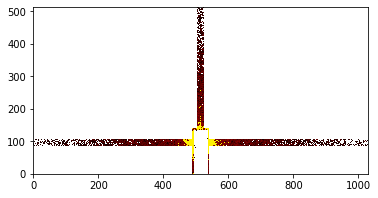

In [113]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax= 1e5), cmap= cmap_albula)
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


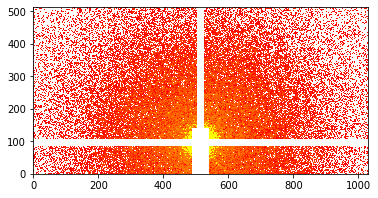

In [114]:
fig, ax = plt.subplots()
im = ax.imshow((mask)*avg_img,  cmap= cmap_albula,origin='lower',
               norm= LogNorm( vmin=.1e-3, vmax=1e2 ),
               interpolation='none')
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

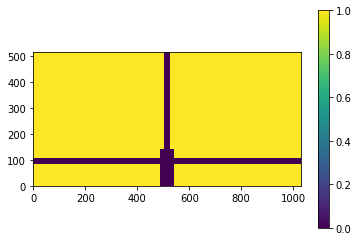

In [115]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

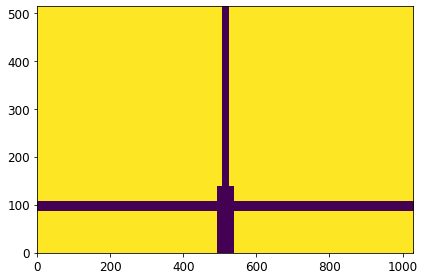

In [116]:
# adding the hot pixels
#mask[1217:1237,1150:1170] = 0

# extra hot pixel corrections
show_img(mask, show_colorbar=False   )

## Save the combined mask to use in further data analysis

In [117]:
np.save(  path +   uid +"_mask", mask)

In [118]:
path +   uid +"_mask"

'/XF11ID/analysis/2019_3/masks/7d93c742_mask'

#### save with a meaningful filename, make False after excute to avoid overwrite

In [120]:
#if True:
if False:    
    date='Nov4'
    if '4m' in md['detector']:
        meaningful_name = '%s_2019_4M_SAXS'%date#_centered'
    elif '500K' in md['detector']:
        meaningful_name = '%s_2019_500K_SAXS'%date#_centered'
    np.save(  path +   meaningful_name, mask)
    print( path +   meaningful_name )
    

In [123]:
path +   meaningful_name

'/XF11ID/analysis/2019_3/masks/Nov4_2019_500K_SAXS'

In [122]:
uid

'7d93c742'